In [10]:
#Why do we hypertune?
# We hypertune to get the agent to learn faster.  And so it requires less timesteps to be an optimal learned agent..

# importing library
import numpy as np
from stable_baselines3.common.vec_env import SubprocVecEnv
from stable_baselines3 import PPO
import optuna
import gym
from torch import nn as nn
import joblib
import gym_anytrading
import yfinance as yf
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from matplotlib import pyplot as plt
import finta as TA #technical indicators library imported..
from gym_anytrading.envs import StocksEnv
from gym import Env
from gym.spaces import Discrete, Box
from gym import spaces
from gym.utils import seeding
import pandas as pd
from stable_baselines3.common.evaluation import evaluate_policy


In [11]:

# define optimization agent for Optuna
#Runs per trial model to make sure that runs are generally returning positive returns
nOptimzeRuns = 10

#training timesteps per trial
nOptimizeTrains = 10000

# number of optuna trials
nOptunaTrials = 50


In [12]:
# This is the trading training environment
class TradingEnv(gym.Env):

    metadata = { 'render.modes': [ 'human' ] }

    def __init__(self, df, loss_constraint=0.4):

        super(TradingEnv, self).__init__()

        self.df = df
        #print(df.shape)
        self.metrics = []
        self.step_index = 0
        
        # Position size from 1 to 10
        self._position = 0
        # Initial Action 
        self._action = "NONE"
        self._reward = 0
        self._cumulative_reward = 0
        self._max_cumulative_reward = 0
        self.loss_constraint = loss_constraint
        
        self.action_space = spaces.Discrete(20)
        self.observation_space = spaces.Box(low=0, high=1, shape=(1,), dtype=np.float16)

    def step(self, action):
        done=False
        self._take_action(action)
        self._reward = self.compute_reward()
        reward = self._reward
        self._cumulative_reward = self._cumulative_reward + reward
        self.step_index +=1
        
        # keeping track of maximum cumulative return
        if self._cumulative_reward > self._max_cumulative_reward:
            self._max_cumulative_reward = self._cumulative_reward

        # if current accumulated reward is less than max reward achieved in the past by more than 40%
        # you have lost 40% of accrued capital, it's time to stop-out
        if (self._cumulative_reward - self._max_cumulative_reward) < (self.loss_constraint*-1):
            #print('Agent losses')
            #reward = 
            #self._cumulative_reward = self._cumulative_reward + reward
            done=True
        
        info = self._compute_step_info(reward)
        self.metrics.append(info)

        if self.step_index == (self.df.shape[0]-1):
            done = True
        
        if done:
            self.metrics = []
            self.step_index = 0
                #print("Agent Gets Positive Returns!!!")
        obs = self._next_observation()
        
        return obs, reward, done, info

    def reset(self):
        #self.df=df
        self.metrics = []
        self.step_index = 0
        self._reward = 0
        self._cumulative_reward = 0
        self._max_cumulative_reward = 0
        
        # initial position is zero contracts
        self._position = 0
        # Initial Action 
        self._action = "NONE"
        #print(self.df.iloc[0,1])

        return self._next_observation()
    
    def _compute_step_info(self, reward):
        return {
            'Date': self.df.index[self.step_index],
            'Action': self._direction,
            'Contracts': np.abs(self._position),
            'UnLevered Return': np.round(reward*100/np.abs(self._position),3),
            'Levered Return': np.round(reward*100,3),
            'Cumulative Levered Return': np.round(self._cumulative_reward*100,3),
            'Max Cumulative Levered Return': np.round(self._max_cumulative_reward*100,3)
            
           
        }

    def _next_observation(self):
        
        #print(df.shape)
        obs = np.array([
            self.df.iloc[self.step_index, 1],
            #self.df.iloc[self.step_index, 2],
        ])
        return obs

    def _take_action(self, action):
        action = action + 1
        if action <=10:
            self._position = action
            self._direction = "BUY"
        
        else:
            self._position = 10-action
            self._direction = "SELL"
        
    def compute_reward(self):
        
        reward = self._position * self.df.iloc[self.step_index, 0]
        

        return reward
    
    def render(self, mode='human'):
        pass
    
    def close(self):
        pass

In [13]:
# callback class for Optuna early stopping
# Reference: https://medium.com/analytics-vidhya/hyperparameter-tuning-using-optuna-for-finrl-8a49506d2741
class LoggingCallback:
    def __init__(self,threshold,trial_number,patience):
      '''
      threshold:int tolerance for increase in reward
      trial_number: int Prune after minimum number of trials
      patience: int patience for the threshold
      '''
      self.threshold = threshold
      self.trial_number  = trial_number
      self.patience = patience
      self.cb_list = [] #Trials list for which threshold is reached
    def __call__(self,study:optuna.study, frozen_trial:optuna.Trial):
      #Setting the best value in the current trial
      study.set_user_attr("previous_best_value", study.best_value)
      
      #Checking if the minimum number of trials have pass
      if frozen_trial.number >self.trial_number:
          previous_best_value = study.user_attrs.get("previous_best_value",None)
          #Checking if the previous and current objective values have the same sign
          if previous_best_value * study.best_value >=0:
              #Checking for the threshold condition
              if abs(previous_best_value-study.best_value) < self.threshold: 
                  self.cb_list.append(frozen_trial.number)
                  #If threshold is achieved for the patience amount of time
                  if len(self.cb_list)>self.patience:
                      print('The study stops now...')
                      print('With number',frozen_trial.number ,'and value ',frozen_trial.value)
                      print('The previous and current best values are {} and {} respectively'
                              .format(previous_best_value, study.best_value))
                      study.stop()


,Dependent,Feature1
Date,,
2021-11-08,0.000000,0.000000
2021-11-09,-0.003311,0.000000
2021-11-10,-0.008077,-0.003311
2021-11-11,0.000323,-0.008077
2021-11-12,0.007518,0.000323


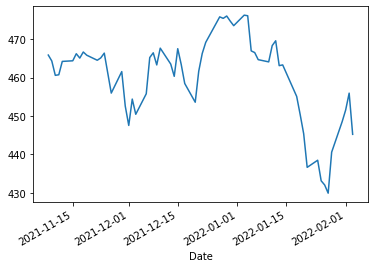

In [14]:
#read spy data
#load df with return as the dependent variable and feature1
df = yf.download('SPY', start='2021-11-06', end='2022-02-06', progress=False)
df.drop("Close", axis=1, inplace=True)
df.rename(columns = {'Adj Close':'Close'}, inplace = True)
df.head()
df.fillna(0,inplace=True)
df.drop(df.tail(1).index,inplace=True) # drop last n rows
df.head(5)
df.drop("Open", axis=1, inplace=True)
df.drop("High", axis=1, inplace=True)
df.drop("Low", axis=1, inplace=True)
df.drop("Volume", axis=1, inplace=True)
df["Close"].plot()
df["Dependent"]=df["Close"].pct_change(1) # 1 for ONE DAY lookback
df['Dependent'] = np.log(1 + df.Dependent)
df['Feature1']=df['Dependent'].shift(1)
df.drop("Close", axis=1, inplace=True)
df.fillna(0,inplace=True)
df.head(5)


In [15]:
# create environment
def make_env(rank, df):
    #"""
    #Utility function for multiprocessed env.

    #:param num_env: (int) the number of environments you wish to have in subprocesses
    #:param rank: (int) index of the subprocess
    #"""
    def _init():
        env = TradingEnv(df=df, loss_constraint=0.4)
        
        return env
    
    return _init
num_cpu = 5
env = SubprocVecEnv([make_env(i, df) for i in range(num_cpu)])
env = VecNormalize(env, norm_obs=True, norm_reward=True)



In [16]:
## define PPO hyperparameters
def optimize_ppo(trial):
    """ Learning hyperparamters we want to optimise"""
    #net_arch = trial.suggest_categorical("net_arch", ["small", "medium"])
    #activation_fn = trial.suggest_categorical("activation_fn", ["tanh", "relu"])
    #net_arch = { "small": [dict(pi=[64, 64], vf=[64, 64])], "medium": [dict(pi=[256, 256], vf=[256, 256])],}[net_arch]

    
    #activation_fn = {"tanh": nn.Tanh, "relu": nn.ReLU, "elu": nn.ELU, "leaky_relu": nn.LeakyReLU}[activation_fn]
    #ortho_init = False
    return {
         'gamma': trial.suggest_categorical("gamma", [0.99, 0.995, 0.999, 0.9999]),
         'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1.),
          #'n_steps': trial.suggest_categorical("n_steps", [8, 16, 32, 64, 128, 256, 512, 1024, 2048]),
           #'n_epochs': trial.suggest_categorical("n_epochs", [1, 5, 10, 20]),
            'batch_size': trial.suggest_categorical("batch_size", [8, 16, 32, 64, 128, 256, 512]),
            #'clip_range': trial.suggest_categorical("clip_range", [0.1, 0.2, 0.3, 0.4]),
            #'vf_coef': trial.suggest_uniform("vf_coef", 0, 1),
            #'ent_coef': trial.suggest_loguniform("ent_coef", 0.00000001, 0.1),
            #'max_grad_norm': trial.suggest_categorical("max_grad_norm", [0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 5]),
            #'gae_lambda': trial.suggest_categorical("gae_lambda", [0.8, 0.9, 0.92, 0.95, 0.98, 0.99, 1.0]),
            #"policy_kwargs": dict(net_arch=net_arch,activation_fn=activation_fn, ortho_init=ortho_init,)
         }

def optimize_agent(trial):
    """ Train the model and optimise
        Optuna maximises the negative log likelihood, so we
        need to negate the reward here
    """
    model_params = optimize_ppo(trial)
    rewards = []
    n_episodes, reward_sum = 0, 0.0

    model = PPO('MlpPolicy', env, verbose=0, **model_params)
    model.learn(nOptimizeTrains)
    model.save('PPO_{}.pth'.format(trial.number))
    obs = env.reset()
    n_episodes, reward_sum = 0, 0.0
    rewards, std_reward = evaluate_policy(model, env, n_eval_episodes=nOptimzeRuns, deterministic=True,return_episode_rewards=True)
    return np.min(rewards) 



In [17]:
# set an optuna sampler, TPE is the best
sampler = optuna.samplers.TPESampler(seed=42)

# setup study environment for Optuna
study = optuna.create_study(study_name="PPO_study",direction='maximize',
                            sampler = sampler, pruner=optuna.pruners.HyperbandPruner())

# setup early callback
logging_callback = LoggingCallback(threshold=1e-5,patience=200,trial_number=30)


[I 2022-03-22 08:53:22,571] A new study created in memory with name: PPO_study


In [18]:
# run optuna for ten trials
study.optimize(optimize_agent, n_trials=nOptunaTrials,catch=(ValueError,),callbacks=[logging_callback])


c:\users\chirag\anaconda3\envs\my_rl_env\lib\site-packages\stable_baselines3\common\evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(
[I 2022-03-22 08:53:37,557] Trial 0 finished with value: 2.086596106304442 and parameters: {'gamma': 0.995, 'learning_rate': 6.0268891286825045e-05, 'batch_size': 512}. Best is trial 0 with value: 2.086596106304442.
c:\users\chirag\anaconda3\envs\my_rl_env\lib\site-packages\stable_baselines3\common\evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(
[I 2022-03-22 08:54:02,295] Trial 1 finished w

c:\users\chirag\anaconda3\envs\my_rl_env\lib\site-packages\stable_baselines3\common\evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(
[I 2022-03-22 09:06:34,650] Trial 14 finished with value: 2.7412599372372055 and parameters: {'gamma': 0.99, 'learning_rate': 0.0038522649362480086, 'batch_size': 8}. Best is trial 13 with value: 4.779145067940336.
c:\users\chirag\anaconda3\envs\my_rl_env\lib\site-packages\stable_baselines3\common\evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(
[I 2022-03-22 09:08:28,362] Trial 15 finished w

c:\users\chirag\anaconda3\envs\my_rl_env\lib\site-packages\stable_baselines3\common\evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(
[I 2022-03-22 09:22:03,790] Trial 28 finished with value: -1.3711625693607998 and parameters: {'gamma': 0.995, 'learning_rate': 3.891376864408778e-05, 'batch_size': 32}. Best is trial 13 with value: 4.779145067940336.
c:\users\chirag\anaconda3\envs\my_rl_env\lib\site-packages\stable_baselines3\common\evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(
[I 2022-03-22 09:22:17,076] Trial 29 finishe

c:\users\chirag\anaconda3\envs\my_rl_env\lib\site-packages\stable_baselines3\common\evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(
[I 2022-03-22 09:34:47,598] Trial 42 finished with value: -1.2259260469690387 and parameters: {'gamma': 0.995, 'learning_rate': 7.600691139036478e-05, 'batch_size': 64}. Best is trial 13 with value: 4.779145067940336.
c:\users\chirag\anaconda3\envs\my_rl_env\lib\site-packages\stable_baselines3\common\evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(
[I 2022-03-22 09:35:10,314] Trial 43 finishe

In [19]:
#show the saved model...
trial = study.best_trial
print(study.best_trial.number)
print('Reward: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))


47
Reward: 4.8797839432413035
Best hyperparameters: {'gamma': 0.9999, 'learning_rate': 0.001790926719782026, 'batch_size': 128}


[[0.]]


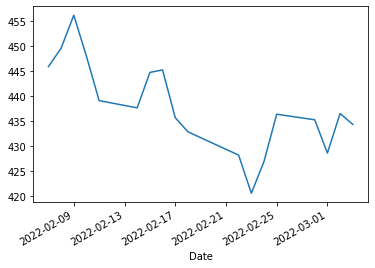

In [20]:
#Load test data 

df = yf.download('SPY', start='2022-02-07', end='2022-03-06', progress=False)
df.drop("Close", axis=1, inplace=True)
df.rename(columns = {'Adj Close':'Close'}, inplace = True)
df.head()
df.fillna(0,inplace=True)
df.drop(df.tail(1).index,inplace=True) # drop last n rows
df.head(5)
df.drop("Open", axis=1, inplace=True)
df.drop("High", axis=1, inplace=True)
df.drop("Low", axis=1, inplace=True)
df.drop("Volume", axis=1, inplace=True)
df["Close"].plot()
df["Dependent"]=df["Close"].pct_change(1) # 1 for ONE DAY lookback
df['Dependent'] = np.log(1 + df.Dependent)
df['Feature1']=df['Dependent'].shift(1)
df.drop("Close", axis=1, inplace=True)
df.fillna(0,inplace=True)
df.head(10)

# create environment
env = TradingEnv(df=df, loss_constraint=0.4)
env_maker = lambda: env
env = DummyVecEnv([env_maker])
env = VecNormalize.load("vec_normalize.pkl", env)
env.norm_obs =True
# reward normalization is not needed at test time
env.norm_reward = True
obs = env.reset()
print(obs)

Total Cumulative Levered Return (%):  6.864


<AxesSubplot:title={'center':'Test: Cumulative Levered Returns'}, xlabel='Date'>

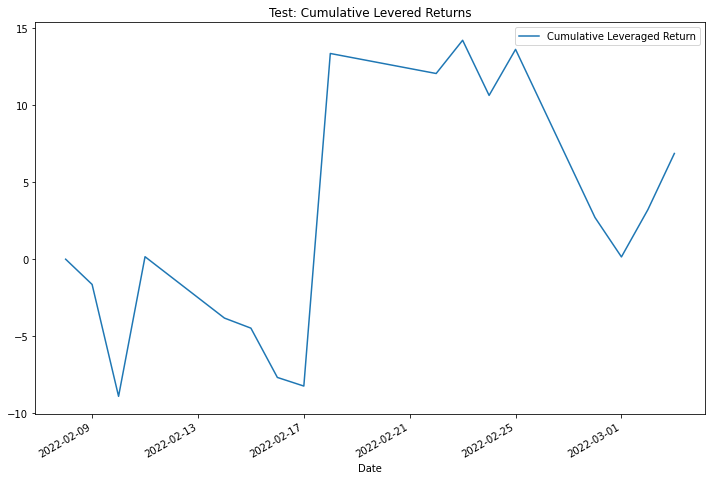

In [21]:

rewards = []
cumulative_returns =pd.DataFrame(columns=['Date', 'Cumulative Leveraged Return'])
n_episodes, reward_sum = 0, 0.0

obs = env.reset()
#load best PPO model
tuned_model_PPO = PPO.load('PPO_{}.pth'.format(study.best_trial.number),env=env)

while n_episodes < 1:
    
    action, _ = tuned_model_PPO.predict(obs, deterministic=True)
    
    obs, reward, done, info = env.step(action)
    newRow={'Date':info[0]["Cumulative Levered Return"],'Cumulative Leveraged Return':info[0]["Cumulative Levered Return"]}
    df2 = pd.DataFrame({'Date': [info[0]["Date"]],
                    'Cumulative Leveraged Return' : [info[0]["Cumulative Levered Return"]]})

    cumulative_returns = pd.concat([cumulative_returns, df2], ignore_index = True, axis = 0)

    #print(info)
    
    if done:
        rewards = (info[0]["Cumulative Levered Return"])
        n_episodes += 1
        obs = env.reset()



env.close()
last_reward = rewards
print("Total Cumulative Levered Return (%): ",last_reward)
cumulative_returns['Date'] = pd.to_datetime(cumulative_returns['Date'])
cumulative_returns.set_index('Date', inplace=True)
cumulative_returns.head(5)
cumulative_returns.plot(title="Test: Cumulative Levered Returns", figsize=(12,8))